# Library

In [42]:
import pandas as pd
import numpy as np
import ast
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
import gender_guesser.detector as gender


## Imports Datasets from Kaggle

In [43]:
from typing import Optional

from transformers.models.esm.openfold_utils.protein import from_prediction
!pip install kagglehub

Python(9981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


## Dataset Loading 
#### Normally datasets are downloaded from the Kaggle, but in the purpose of time-saving the local path placed instead.
#### If you want to download the datasets again, just uncomment the code below.

In [44]:
path = "/Users/masoud/Downloads/yelp_academic_dataset/yelp_ parquet"

# path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")

# print("Path to dataset files:", path)

## Loading Yelp Hours Dataset
### Overview
### In this section, we analyze the Yelp Hours Dataset, which provides information about the operating hours of businesses listed on Yelp. This dataset includes details about which days of the week businesses are open.

In [45]:
df_yelp_hours = pd.read_parquet(f"{path}/Hours.parquet")
df_yelp_hours.head(5)

business_id     monday    tuesday  wednesday   thursday  \
0  FYWN1wneV18bWNgQjJ2GNg  7:30-17:0  7:30-17:0  7:30-17:0  7:30-17:0   
1  He-G7vWjzVUysIKrfNbPUQ   9:0-20:0   9:0-20:0   9:0-20:0   9:0-20:0   
2  KQPW8lFf1y5BT2MxiSZ3QA       None       None       None       None   
3  8DShNS-LuFqpEWIp0HxijA  10:0-21:0  10:0-21:0  10:0-21:0  10:0-21:0   
4  PfOCPjBrlQAnz__NXj9h_w   11:0-1:0   11:0-1:0   11:0-1:0   11:0-1:0   

      friday   saturday     sunday  
0  7:30-17:0       None       None  
1   9:0-16:0   8:0-16:0       None  
2       None       None       None  
3  10:0-21:0  10:0-21:0  11:0-19:0  
4   11:0-1:0   11:0-2:0   11:0-0:0

## 1. Basic Info
### Check the structure of the dataset.

In [46]:
print(df_yelp_hours.info())
print(df_yelp_hours.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  174567 non-null  object
 1   monday       174567 non-null  object
 2   tuesday      174567 non-null  object
 3   wednesday    174567 non-null  object
 4   thursday     174567 non-null  object
 5   friday       174567 non-null  object
 6   saturday     174567 non-null  object
 7   sunday       174567 non-null  object
dtypes: object(8)
memory usage: 10.7+ MB
None
business_id    0
monday         0
tuesday        0
wednesday      0
thursday       0
friday         0
saturday       0
sunday         0
dtype: int64


## 2. Counting Operating Days & Visualizing Distribution
### Creating visualizations to explore the distribution of operating days across different businesses.

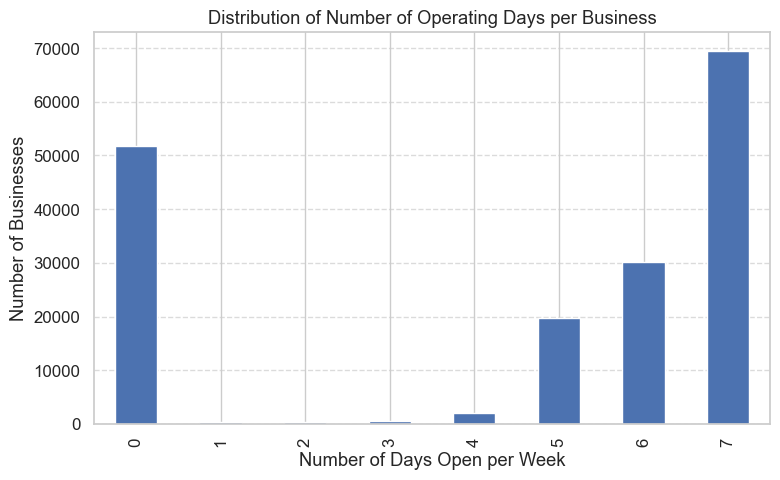

In [47]:
# Function to count operating days
def count_open_days_new_format(df, days_cols=None, new_col='Number of Operating Days'):
    """
    Counts the number of days a business is open based on separate weekday columns.

    Parameters:
    df (pd.DataFrame): The dataset containing business hours per weekday.
    days_cols (list): List of column names for each day of the week.
    new_col (str): New column name to store the count of open days.

    Returns:
    pd.DataFrame: Updated DataFrame with the new column.
    """
    if days_cols is None:
        days_cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

    def is_open(hours):
        if pd.isna(hours) or hours.lower() in ["none", "nan", "0:0-0:0", "closed"]:
            return 0
        return 1

    df[new_col] = df[days_cols].apply(lambda row: sum(is_open(row[day]) for day in days_cols), axis=1)
    
    return df

# Apply the function
df_yelp_hours = count_open_days_new_format(df_yelp_hours)

# Plotting the distribution
plt.figure(figsize=(8, 5))
df_yelp_hours['Number of Operating Days'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Number of Operating Days per Business')
plt.xlabel('Number of Days Open per Week')
plt.ylabel('Number of Businesses')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Loading Yelp Business Dataset

## Overview
### In this part, we are analyzing the **Yelp Business Dataset**, which provides information about businesses listed on Yelp. This dataset contains attributes such as location, categories, ratings, reviews, and hours.


In [58]:
df_yelp_business = pd.read_parquet(f"{path}/Business.parquet")
df_yelp_business.head(5)

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"         None   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"         None   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"         None   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"         None   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"         None   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

    latitude   longitude  stars  review_count  is_open  \
0  33.330690 -111.978599    4.0            22        1   
1  40.291685  -80.104900    3.0            11        1   
2  33.524903 -112.115310    1.5            18        1   
3  33.383147 -111.964725    3.0             9        0   
4  41.119535  -81.475690    3.5           116        1   

                                          categories  
0  Dentists;General Dentistry;Health & Medical;Or...  
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...  
2  Departments of Motor Vehicles;Public Services ...  
3                            Sporting Goods;Shopping  
4  American (New);Nightlife;Bars;Sandwiches;Ameri...

## 1. Initial Review of Dataset

### This function performs an **initial exploratory analysis** providing key insights into its structure and contents.

### Business Distribution by State (Percentage-Based)

This visualization **displays the percentage of unique businesses (`business_id`) in each state** from the Yelp business dataset.


In [59]:
def perform_eda(df):
    """
    Performs Exploratory Data Analysis (EDA) on a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input dataset

    Returns:
    None
    """

    print("🔹 Dataset Overview 🔹")
    print("\nDataset Info:")
    print(df.info())

    print("\nDataset Shape:", df.shape)

    print("\nMissing Values:")
    print(df.isnull().sum())



# Call the function with df_yelp_business
perform_eda(df_yelp_business)

🔹 Dataset Overview 🔹

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   174567 non-null  object 
 1   name          174567 non-null  object 
 2   neighborhood  68015 non-null   object 
 3   address       174567 non-null  object 
 4   city          174566 non-null  object 
 5   state         174566 non-null  object 
 6   postal_code   173944 non-null  object 
 7   latitude      174566 non-null  float64
 8   longitude     174566 non-null  float64
 9   stars         174567 non-null  float64
 10  review_count  174567 non-null  int64  
 11  is_open       174567 non-null  int64  
 12  categories    174567 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 17.3+ MB
None

Dataset Shape: (174567, 13)

Missing Values:
business_id          0
name                 0
neighborhood    106552
address   

## 2. Top 20 States by Percentage of Businesses
### This horizontal bar chart visualizes the top 20 U.S. states based on the percentage of businesses registered in each, according to the provided dataset.

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/3068475790.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


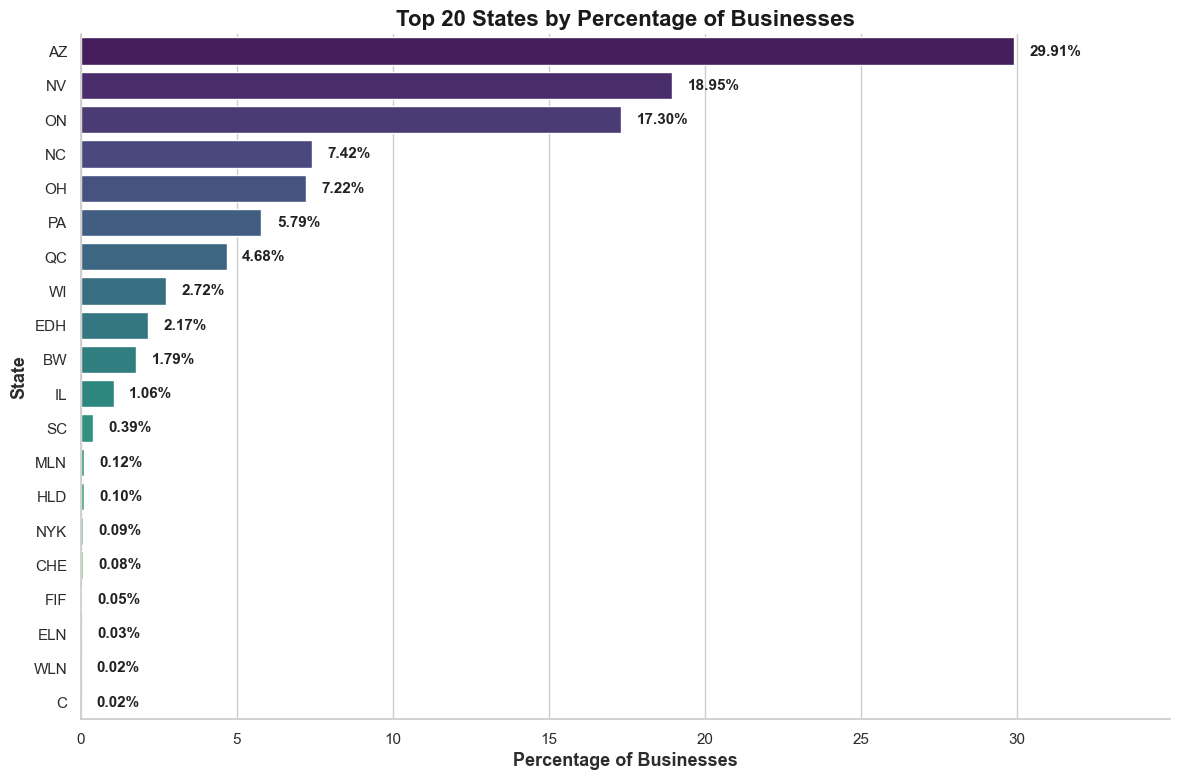

In [60]:
def plot_top_20_business_percentage_by_state(df, state_col='state', business_col='business_id'):
    """
    Plots a horizontal bar chart showing the top 20 states with the highest percentage of businesses.

    Parameters:
    df (pd.DataFrame): The input dataset.
    state_col (str): Column name for states.
    business_col (str): Column name for business IDs.

    Returns:
    None
    """
    # Font and style
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    sns.set_style("whitegrid")

    # Compute percentages
    total_businesses = df[business_col].nunique()
    state_counts = df.groupby(state_col)[business_col].nunique().reset_index()
    state_counts['percentage'] = (state_counts[business_col] / total_businesses) * 100

    # Sort and limit to top 20
    top_20_states = state_counts.sort_values(by='percentage', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(
        data=top_20_states,
        y=state_col,
        x='percentage',
        palette='viridis'
    )

    # Add labels to bars
    for i, val in enumerate(top_20_states['percentage']):
        plt.text(val + 0.5, i, f"{val:.2f}%", va='center', fontsize=11, color="#222222", weight='bold')

    # Labels and aesthetics
    plt.title("Top 20 States by Percentage of Businesses", fontsize=16, fontweight="bold", color="#1a1a1a")
    plt.xlabel("Percentage of Businesses", fontsize=13, fontweight="bold", color="#2c2c2c")
    plt.ylabel("State", fontsize=13, fontweight="bold", color="#2c2c2c")
    plt.xticks(fontsize=11, color="#2c2c2c")
    plt.yticks(fontsize=11, color="#2c2c2c")

    plt.xlim(0, top_20_states['percentage'].max() + 5)
    sns.despine()
    plt.tight_layout()
    plt.show()

# Call the function
plot_top_20_business_percentage_by_state(df_yelp_business[['business_id', 'state']])


## 3. Yelp Business Heatmap Visualization

### This script creates an interactive map using Folium, centered around the average location of businesses from the Yelp dataset. A heatmap layer is added to visualize business density.


In [61]:
# Drop rows where latitude or longitude is missing
df_clean = df_yelp_business.dropna(subset=['latitude', 'longitude'])

# Create a map centered around the average location
m = folium.Map(
    location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()],
    zoom_start=5
)

# Prepare clean heatmap data
heat_data = list(zip(df_clean.latitude, df_clean.longitude))

# Add the heatmap layer
HeatMap(heat_data, radius=8).add_to(m)

# Display the map
m

## 4. Open vs. Closed Businesses Analysis

### This script analyzes the **business status** in the dataset, categorizing businesses as either **Open (1)** or **Closed (0)**. The results are visualized using a **bar chart** and printed numerically.

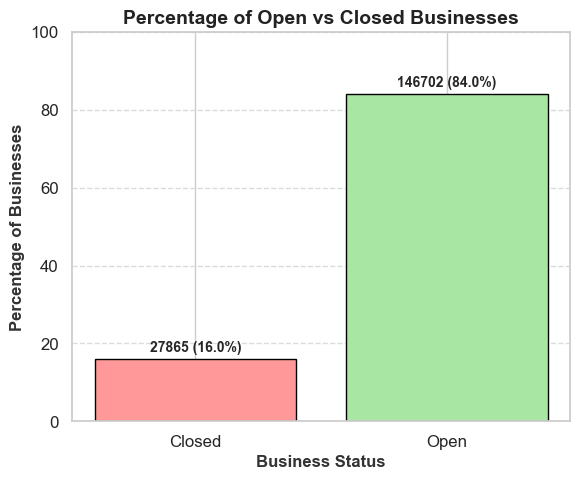

Number of Open Businesses: 146702
Number of Closed Businesses: 27865


In [62]:
def plot_open_closed_businesses(df, status_col='is_open'):
    """
    Plots a bar chart showing the percentage of open vs closed businesses.

    Parameters:
    df (pd.DataFrame): The input dataset.
    status_col (str): Column name indicating business status (1 for open, 0 for closed).

    Returns:
    None
    """
    
    # Define soft colors
    light_red = "#FF9999"
    light_green = "#A8E6A3"

    # Count open vs closed businesses
    open_counts = df[status_col].value_counts().sort_index()
    open_percentages = df[status_col].value_counts(normalize=True).sort_index() * 100

    # Create the bar chart
    plt.figure(figsize=(6, 5))
    bars = plt.bar(['Closed', 'Open'], open_percentages, color=[light_red, light_green], edgecolor='black')

    # Customize the chart appearance
    plt.xlabel("Business Status", fontsize=12, fontweight="bold", color="#333333")
    plt.ylabel("Percentage of Businesses", fontsize=12, fontweight="bold", color="#333333")
    plt.title("Percentage of Open vs Closed Businesses", fontsize=14, fontweight="bold", color="#222222")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the count and percentage on each bar
    for bar, count, percentage in zip(bars, open_counts, open_percentages):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f"{count} ({percentage:.1f}%)", ha='center', fontsize=10, fontweight='bold')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print numerical values outside the chart
    print(f"Number of Open Businesses: {open_counts.get(1, 0)}")
    print(f"Number of Closed Businesses: {open_counts.get(0, 0)}")

# Call the function
plot_open_closed_businesses(df_yelp_business)


## 5. Top 50 Business Categories by Count

### This bar chart visualizes the **50 most common business categories** in the Yelp dataset.


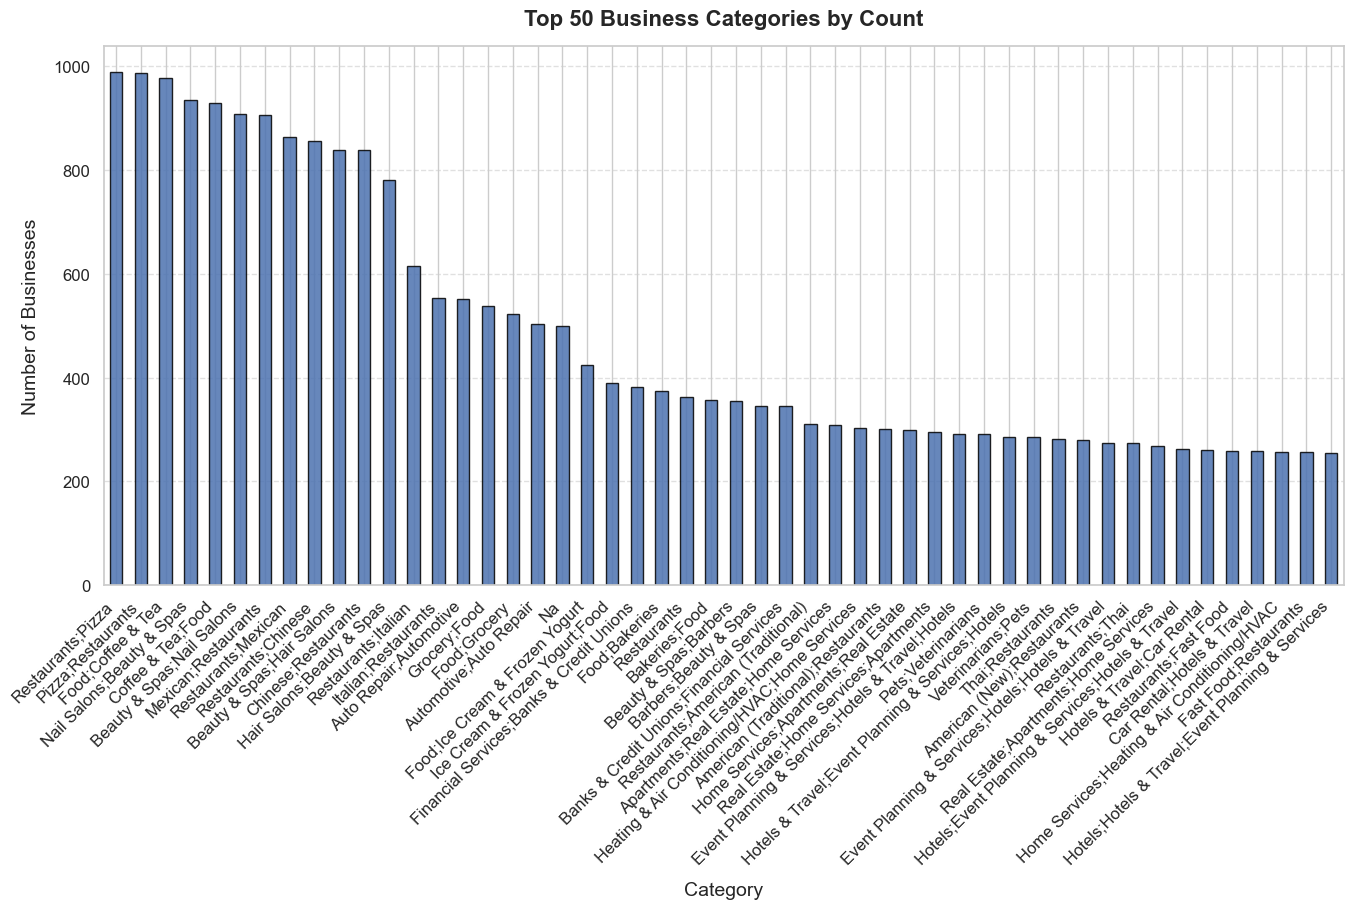

In [63]:
# Explode categories into separate rows
df_exploded = df_yelp_business.assign(category=df_yelp_business['categories'].str.split(', ')).explode('category')

# Count occurrences of each category
category_counts = df_exploded['category'].value_counts()

# Plot bar chart for the top 50 categories
plt.figure(figsize=(16, 7))
bars = category_counts.head(50).plot(kind='bar', color='#4C72B0', edgecolor='black', alpha=0.85)

# Enhance labels and title
plt.xlabel("Category", fontsize=14, labelpad=10)
plt.ylabel("Number of Businesses", fontsize=14, labelpad=10)
plt.title("Top 50 Business Categories by Count", fontsize=16, fontweight='bold', pad=15)

# Improve tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Beautify the bars with edge effects
for bar in bars.patches:
    bar.set_linewidth(1)
    bar.set_edgecolor('black')


# Show the plot
plt.show()


## 6. Generalizing Business Categories for Cleaner Analysis

### In this section, we transform Yelp business category data by grouping specific categories into **broader general categories**. This improves readability and helps identify major business sectors more clearly.


In [64]:
from rapidfuzz import process
import matplotlib.pyplot as plt

# Your original mapping dictionary
category_mapping = {
    # [same as your dictionary, no changes here...]
}

# Step 1: Explode categories if not already done
df_yelp_business_categories = df_yelp_business.assign(
    category=df_yelp_business['categories'].str.split(';')
).explode('category')

# Step 2: Fuzzy match function using rapidfuzz
def fuzzy_map(category, choices, threshold=80):
    if pd.isnull(category):
        return None
    match, score, _ = process.extractOne(category.strip(), choices)
    return category_mapping[match] if score >= threshold else None

# Step 3: Apply fuzzy mapping to generalize categories
df_yelp_business_categories['general_category'] = df_yelp_business_categories['category'].apply(
    lambda x: fuzzy_map(x, category_mapping.keys())
)

# Step 4: Drop rows with no mapped general category (optional)
df_general = df_yelp_business_categories.dropna(subset=['general_category'])

# Step 5: Count and plot
general_counts = df_general['general_category'].value_counts()

plt.figure(figsize=(12, 6))
bars = general_counts.head(20).plot(kind='bar', color='#9ACD32', edgecolor='black', alpha=0.85)

plt.xlabel("General Category", fontsize=14, labelpad=10)
plt.ylabel("Number of Businesses", fontsize=14, labelpad=10)
plt.title("Top General Business Categories", fontsize=16, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars.patches:
    bar.set_linewidth(1)
    bar.set_edgecolor('black')

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'rapidfuzz'

In [56]:
df_yelp_business_categories.head(5)

business_id                name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg  "Dental by Design"         None   
0  FYWN1wneV18bWNgQjJ2GNg  "Dental by Design"         None   
0  FYWN1wneV18bWNgQjJ2GNg  "Dental by Design"         None   
0  FYWN1wneV18bWNgQjJ2GNg  "Dental by Design"         None   
0  FYWN1wneV18bWNgQjJ2GNg  "Dental by Design"         None   

                      address       city state postal_code  latitude  \
0  "4855 E Warner Rd, Ste B9"  Ahwatukee    AZ       85044  33.33069   
0  "4855 E Warner Rd, Ste B9"  Ahwatukee    AZ       85044  33.33069   
0  "4855 E Warner Rd, Ste B9"  Ahwatukee    AZ       85044  33.33069   
0  "4855 E Warner Rd, Ste B9"  Ahwatukee    AZ       85044  33.33069   
0  "4855 E Warner Rd, Ste B9"  Ahwatukee    AZ       85044  33.33069   

    longitude  stars  review_count  is_open  \
0 -111.978599    4.0            22        1   
0 -111.978599    4.0            22        1   
0 -111.978599    4.0            22        1   
0 -111.978599    4.0            22        1   
0 -111.978599    4.0            22        1   

                                          categories           category  \
0  Dentists;General Dentistry;Health & Medical;Or...           Dentists   
0  Dentists;General Dentistry;Health & Medical;Or...  General Dentistry   
0  Dentists;General Dentistry;Health & Medical;Or...   Health & Medical   
0  Dentists;General Dentistry;Health & Medical;Or...      Oral Surgeons   
0  Dentists;General Dentistry;Health & Medical;Or...  Cosmetic Dentists   

  general_category  
0           Health  
0           Health  
0           Health  
0           Health  
0           Health

## 7. Exploratory of Star Ratings vs. Review Counts

### This section provides a visual and statistical overview of how businesses are rated and how frequently they are reviewed on Yelp.


Summary Statistics
               stars   review_count
count  174567.000000  174567.000000
mean        3.632196      30.137059
std         1.003739      98.208174
min         1.000000       3.000000
25%         3.000000       4.000000
50%         3.500000       8.000000
75%         4.500000      23.000000
max         5.000000    7361.000000


/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/540867834.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[stars_col].dropna(), y=df[reviews_col].dropna(), palette="coolwarm")


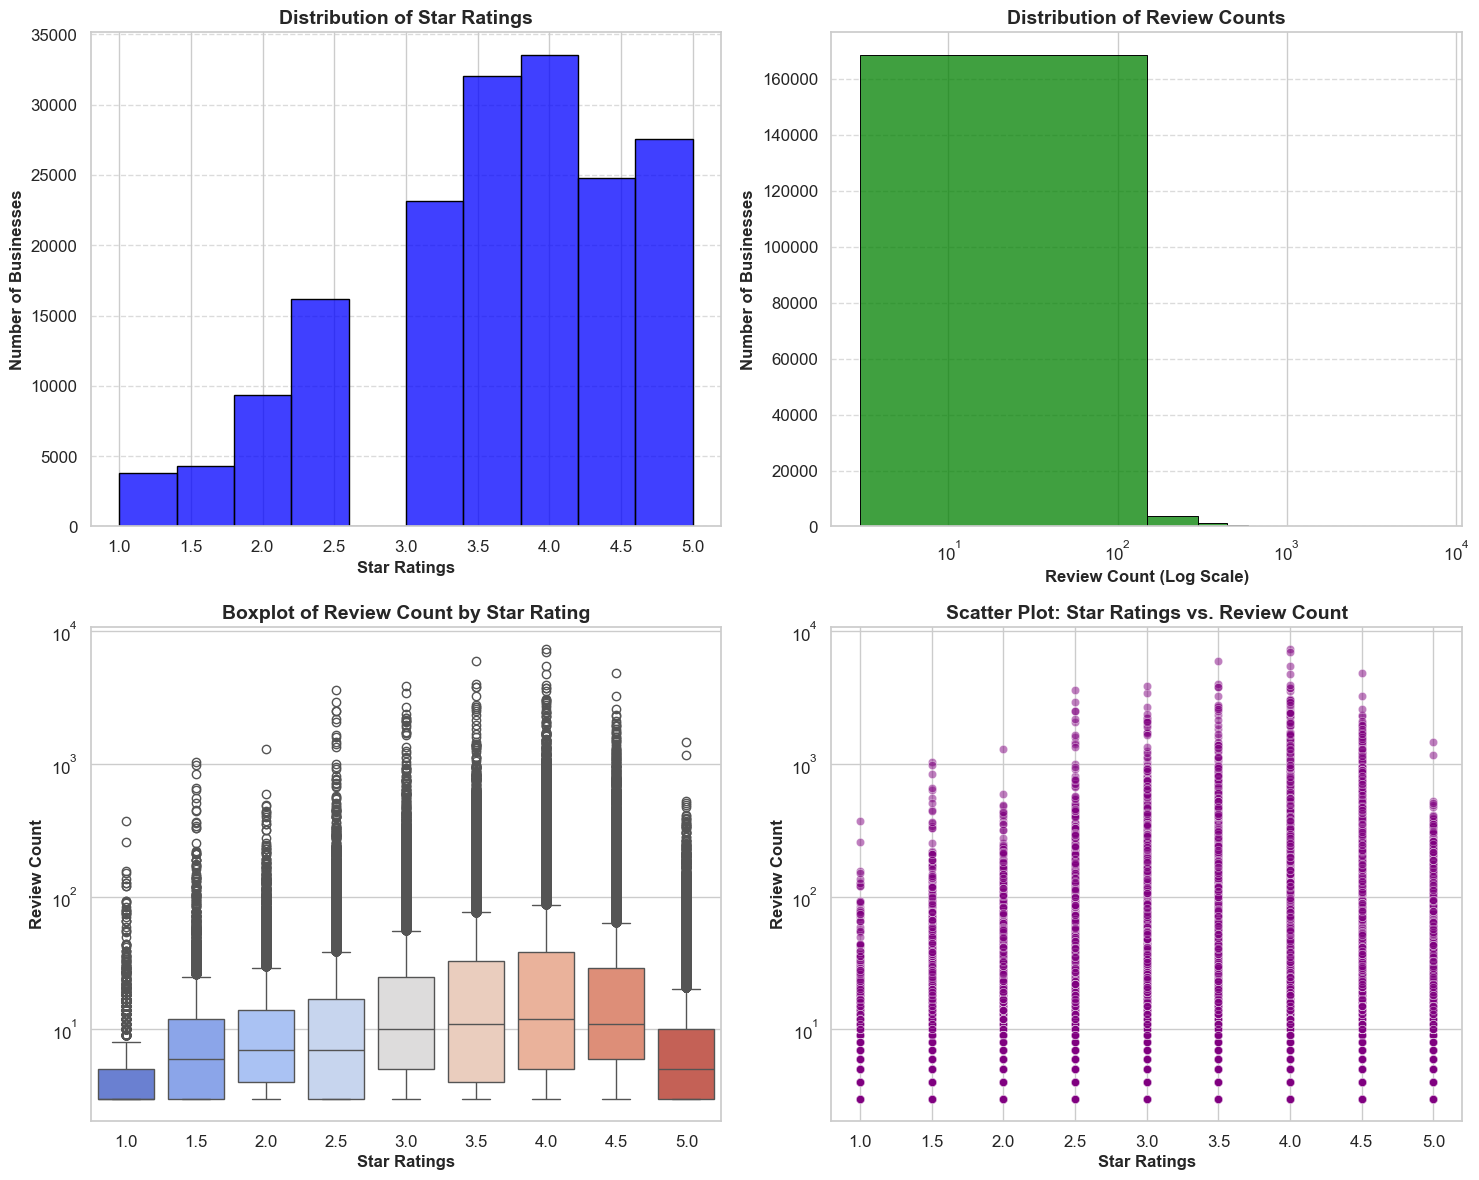

In [57]:
def eda_stars_reviews(df, stars_col='stars', reviews_col='review_count'):
    """
    Performs Exploratory Data Analysis (EDA) on business ratings (stars) and review counts.

    Parameters:
    df (pd.DataFrame): The dataset containing star ratings and review counts.
    stars_col (str): Column name for star ratings.
    reviews_col (str): Column name for review counts.

    Returns:
    None
    """

    # Check unique values to ensure variance
    unique_stars = df[stars_col].nunique()
    unique_reviews = df[reviews_col].nunique()
    
    if unique_stars == 1 or unique_reviews == 1:
        print("⚠ Warning: Your dataset contains only one unique value in either stars or review_count.")
    
    # Summary Statistics
    print("Summary Statistics")
    print(df[[stars_col, reviews_col]].describe())

    # Set figure size
    plt.figure(figsize=(15, 12))

    # Histogram of Ratings (Stars)
    plt.subplot(2, 2, 1)
    sns.histplot(df[stars_col].dropna(), bins=10, kde=False, color="blue", edgecolor="black")
    plt.xlabel("Star Ratings", fontsize=12, fontweight="bold")
    plt.ylabel("Number of Businesses", fontsize=12, fontweight="bold")
    plt.title("Distribution of Star Ratings", fontsize=14, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Histogram of Review Counts (Log Scale)
    plt.subplot(2, 2, 2)
    sns.histplot(df[reviews_col].dropna(), bins=50, kde=False, color="green", edgecolor="black")
    plt.xlabel("Review Count (Log Scale)", fontsize=12, fontweight="bold")
    plt.ylabel("Number of Businesses", fontsize=12, fontweight="bold")
    plt.title("Distribution of Review Counts", fontsize=14, fontweight="bold")
    plt.xscale("log")  # Log scale
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Boxplot: Review Count by Star Rating
    plt.subplot(2, 2, 3)
    sns.boxplot(x=df[stars_col].dropna(), y=df[reviews_col].dropna(), palette="coolwarm")
    plt.xlabel("Star Ratings", fontsize=12, fontweight="bold")
    plt.ylabel("Review Count", fontsize=12, fontweight="bold")
    plt.title("Boxplot of Review Count by Star Rating", fontsize=14, fontweight="bold")
    plt.yscale("log", nonpositive='clip')  # Avoid log(0) errors

    # Scatter Plot: Stars vs. Review Count
    plt.subplot(2, 2, 4)
    sns.scatterplot(x=df[stars_col].dropna(), y=df[reviews_col].dropna(), alpha=0.5, color="purple")
    plt.xlabel("Star Ratings", fontsize=12, fontweight="bold")
    plt.ylabel("Review Count", fontsize=12, fontweight="bold")
    plt.title("Scatter Plot: Star Ratings vs. Review Count", fontsize=14, fontweight="bold")
    plt.yscale("log", nonpositive='clip')  # Avoid log scale issues

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with your dataset
eda_stars_reviews(df_yelp_business)


# Exploratory Data Analysis (EDA) on Yelp Review Dataset

## Overview
### In this section, we analyze the **Yelp Review Dataset**, which contains user-generated reviews left for businesses on Yelp. Reviews include **star ratings, textual feedback, and interaction counts (useful, funny, cool)**. Our goal is to explore the dataset, visualize trends, and extract meaningful insights.


In [18]:
df_yelp_review = pd.read_parquet(f"{path}/Review.parquet")
df_yelp_review.head(5)

review_id                 user_id             business_id  \
0  vkVSCC7xljjrAI4UGfnKEQ  bv2nCi5Qv5vroFiqKGopiw  AEx2SYEUJmTxVVB18LlCwA   
1  n6QzIUObkYshz4dz2QRJTw  bv2nCi5Qv5vroFiqKGopiw  VR6GpWIda3SfvPC-lg9H3w   
2  MV3CcKScW05u5LVfF6ok0g  bv2nCi5Qv5vroFiqKGopiw  CKC0-MOWMqoeWf6s-szl8g   
3  IXvOzsEMYtiJI0CARmj77Q  bv2nCi5Qv5vroFiqKGopiw  ACFtxLv8pGrrxMm6EgjreA   
4  L_9BTb55X0GDtThi6GlZ6w  bv2nCi5Qv5vroFiqKGopiw  s2I_Ni76bjJNK9yG60iD-Q   

   stars        date                                               text  \
0      5  2016-05-28  Super simple place but amazing nonetheless. It...   
1      5  2016-05-28  Small unassuming place that changes their menu...   
2      5  2016-05-28  Lester's is located in a beautiful neighborhoo...   
3      4  2016-05-28  Love coming here. Yes the place always needs t...   
4      4  2016-05-28  Had their chocolate almond croissant and it wa...   

   useful  funny  cool  
0       0      0     0  
1       0      0     0  
2       0      0     0  
3       0      0     0  
4       0      0     0

## Step 1: Distribution of Star Ratings

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/3515556568.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_yelp_review["stars"], palette="viridis")


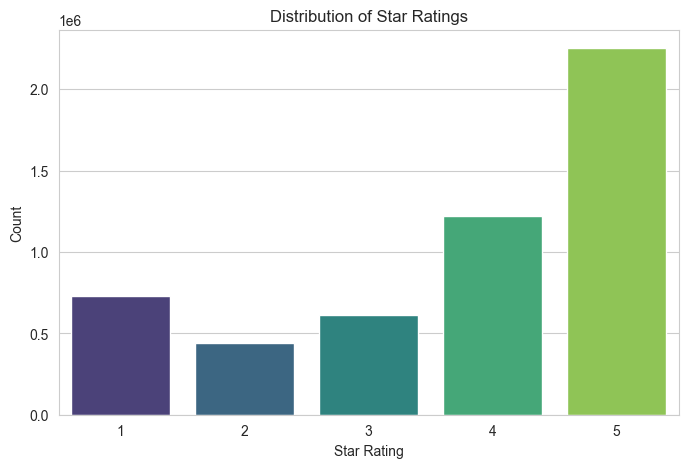

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df_yelp_review["stars"], palette="viridis")
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()

## Step 2. Unique Values Per Column for Orginal Yelp Reviews Dataset 

### As a first step in our analysis, we perform **Exploratory Data Analysis (EDA)** on the review dataset to understand its Unique Values Per Column.


In [20]:
def perform_eda(df):
    """
    Performs Exploratory Data Analysis (EDA) on a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input dataset

    Returns:
    None
    """
    
    print("\n Unique Values Per Column:")
    print(df.nunique())

# Call the function with df_yelp_review
perform_eda(df_yelp_review)


 Unique Values Per Column:
review_id      5261668
user_id        1326101
business_id     174567
stars                5
date              4547
text           5258354
useful             294
funny              255
cool               187
dtype: int64


## Step 3:  Count Missing Values in a DataFrame

In [21]:
def count_missing_values(df):
    """
    Returns a DataFrame showing the count of missing values for each column.
    """
    return df.isnull().sum().reset_index(name="Missing Values")

# Usage example
missing_values_df = count_missing_values(df_yelp_review)
print(missing_values_df)

         index  Missing Values
0    review_id               0
1      user_id               0
2  business_id               0
3        stars               0
4         date               0
5         text               0
6       useful               0
7        funny               0
8         cool               0


## Step 4. Filtering Yelp Reviews for Open Businesses

### In this task, we are working with two datasets:

1. **`df_yelp_review`** — Contains Yelp reviews with fields like `review_id`, `user_id`, `business_id`, `stars`, `date`, `text`.
2. **`df_yelp_business`** — Contains business details including whether the business is currently open or closed.

### To **filter the reviews** (`df_yelp_review`) and keep only those that are associated with **open businesses** in the `df_yelp_business` dataset.


In [22]:
# Step 1: Basic info for df_yelp_review
print("df_yelp_review")
total_reviews = len(df_yelp_review)
print("Number of rows:", total_reviews)
print("Structure:")
print(df_yelp_review.dtypes)
print("\n")

# Step 2: Basic info for df_yelp_business
print("df_yelp_business")
total_businesses = len(df_yelp_business)
print("Number of rows:", total_businesses)
print("Structure:")
print(df_yelp_business.dtypes)
print("\n")

# Step 3: Filter for open businesses
open_business_ids = df_yelp_business[df_yelp_business['is_open'] == 1]['business_id']
df_yelp_review_open = df_yelp_review[df_yelp_review['business_id'].isin(open_business_ids)]

# Step 4: Show filtered review stats
filtered_reviews = len(df_yelp_review_open)
percentage_retained = (filtered_reviews / total_reviews) * 100

print("Filtered Review Stats")
print("Number of reviews after filtering:", filtered_reviews)
print(f"Percentage of reviews retained: {percentage_retained:.2f}%")

df_yelp_review
Number of rows: 5261668
Structure:
review_id      object
user_id        object
business_id    object
stars           int64
date           object
text           object
useful          int64
funny           int64
cool            int64
dtype: object


df_yelp_business
Number of rows: 174567
Structure:
business_id      object
name             object
neighborhood     object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
categories       object
dtype: object


Filtered Review Stats
Number of reviews after filtering: 4643841
Percentage of reviews retained: 88.26%


In [23]:
df_yelp_review_open

review_id                 user_id  \
0        vkVSCC7xljjrAI4UGfnKEQ  bv2nCi5Qv5vroFiqKGopiw   
1        n6QzIUObkYshz4dz2QRJTw  bv2nCi5Qv5vroFiqKGopiw   
2        MV3CcKScW05u5LVfF6ok0g  bv2nCi5Qv5vroFiqKGopiw   
3        IXvOzsEMYtiJI0CARmj77Q  bv2nCi5Qv5vroFiqKGopiw   
4        L_9BTb55X0GDtThi6GlZ6w  bv2nCi5Qv5vroFiqKGopiw   
...                         ...                     ...   
5261662  evfB2Xzw4u7aYftWClQfeg  mPjPyipaD0C_myqWqDipZg   
5261663  PoGSiNz1X5SUu0qEt-qM5w  mPjPyipaD0C_myqWqDipZg   
5261664  -CJNPrDWgIkorx4iEZJXIg  mPjPyipaD0C_myqWqDipZg   
5261666  hqQ1UTFKMN2P1ezUow48OQ  mPjPyipaD0C_myqWqDipZg   
5261667  ldsIs3sGXPJ7WM7VyAm4lQ  mPjPyipaD0C_myqWqDipZg   

                    business_id  stars        date  \
0        AEx2SYEUJmTxVVB18LlCwA      5  2016-05-28   
1        VR6GpWIda3SfvPC-lg9H3w      5  2016-05-28   
2        CKC0-MOWMqoeWf6s-szl8g      5  2016-05-28   
3        ACFtxLv8pGrrxMm6EgjreA      4  2016-05-28   
4        s2I_Ni76bjJNK9yG60iD-Q      4  2016-05-28   
...                         ...    ...         ...   
5261662  --SrzpvFLwP_YFwB_Cetow      2  2011-10-18   
5261663  Ngk84Ax1tXgpoJFEGxot3w      1  2011-11-21   
5261664  pOEL97ld-FJMKO8Ki8JmYg      3  2016-04-30   
5261666  EO3i5kTUG7_S2OIQ23sdSA      3  2011-11-07   
5261667  HloEEXm_QzEpycuwA_RtQA      3  2011-11-15   

                                                      text  useful  funny  \
0        Super simple place but amazing nonetheless. It...       0      0   
1        Small unassuming place that changes their menu...       0      0   
2        Lester's is located in a beautiful neighborhoo...       0      0   
3        Love coming here. Yes the place always needs t...       0      0   
4        Had their chocolate almond croissant and it wa...       0      0   
...                                                    ...     ...    ...   
5261662  So after reading Precilla C. review, I decided...       0      0   
5261663  Bought groupon $39 for 4 months from groupon, ...      36      3   
5261664  Spring rolls was pretty good, cod was a bit ra...       0      0   
5261666  A small, cozy family run Authentic korean rest...       2      0   
5261667  Really nice atmosphere and settings and very c...       0      1   

         cool  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
5261662     0  
5261663     3  
5261664     0  
5261666     0  
5261667     1  

[4643841 rows x 9 columns]

## Step 6. Yelp Reviews Over Time

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/697653948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yelp_review_open["date"] = pd.to_datetime(df_yelp_review_open["date"])


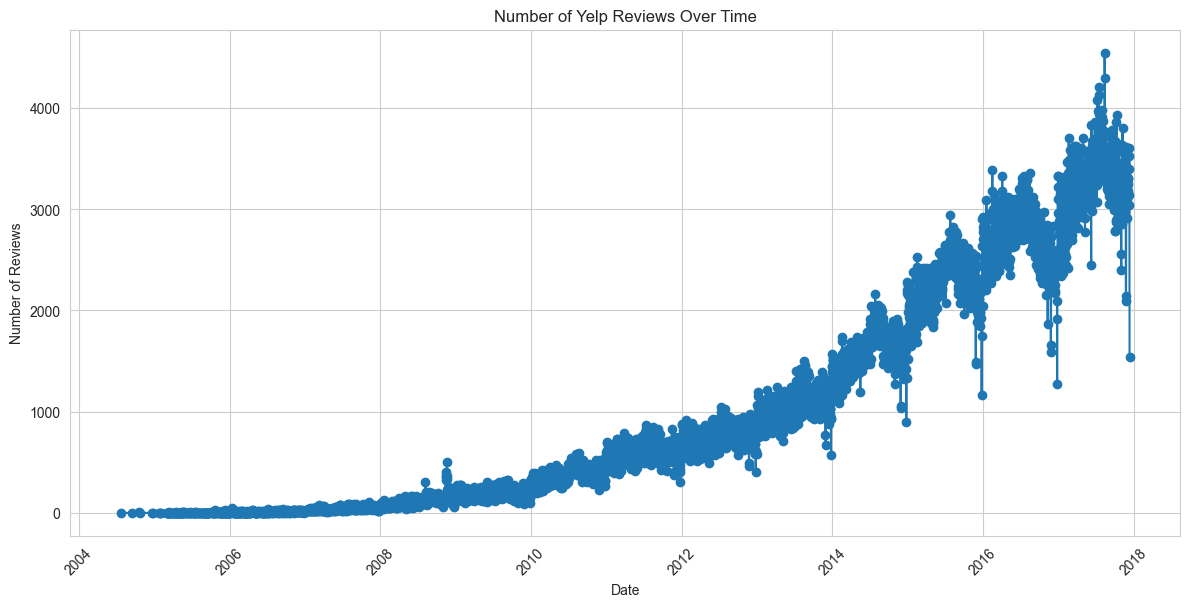

In [24]:
# Ensure 'date' is in datetime format
df_yelp_review_open["date"] = pd.to_datetime(df_yelp_review_open["date"])

# Group by date and count the number of reviews per day
review_counts = df_yelp_review_open.groupby("date").size()

# Plotting the review count over time
plt.figure(figsize=(12, 6))
plt.plot(review_counts.index, review_counts, marker='o', linestyle='-')
plt.title("Number of Yelp Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Step 7: Trend Analysis - Reviews Over Time

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/2848223019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yelp_review_open["date"] = pd.to_datetime(df_yelp_review_open["date"])


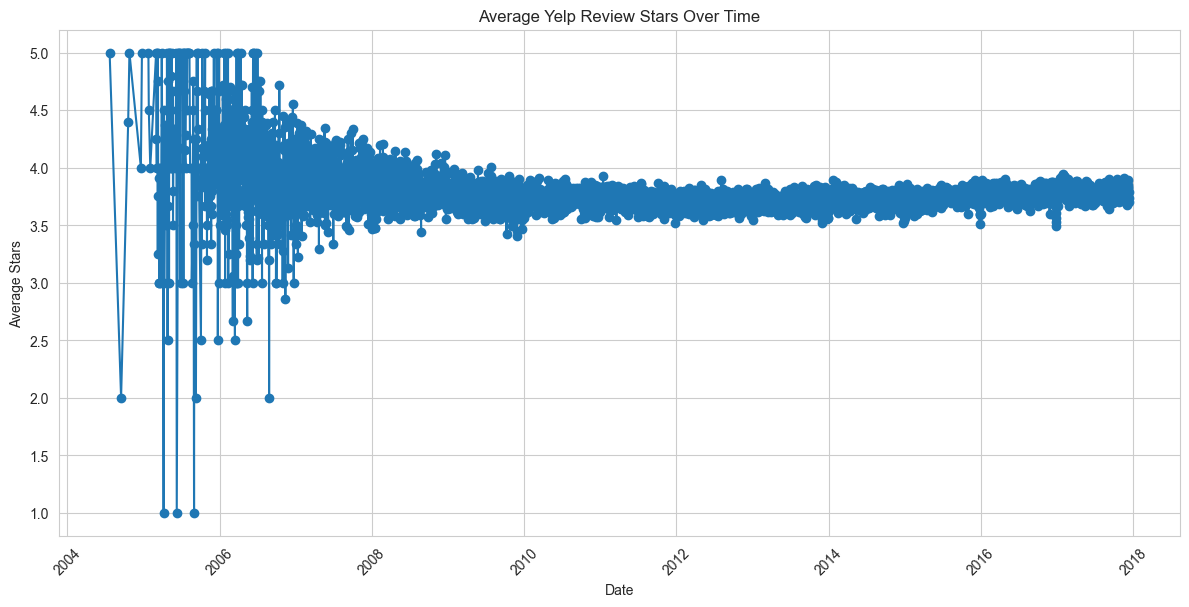

In [25]:
# Ensure 'date' is in datetime format
df_yelp_review_open["date"] = pd.to_datetime(df_yelp_review_open["date"])

# Group by date and calculate average star rating per day
reviews_over_time = df_yelp_review_open.groupby("date")["stars"].mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(reviews_over_time.index, reviews_over_time, marker='o', linestyle='-')
plt.title("Average Yelp Review Stars Over Time")
plt.xlabel("Date")
plt.ylabel("Average Stars")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Step 8: Trend Analysis - Reviews Over Time

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/3368488087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yelp_review_open["date"] = pd.to_datetime(df_yelp_review_open["date"])
/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/3368488087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yelp_review_open["year"] = df_yelp_review_open["date"].dt.year


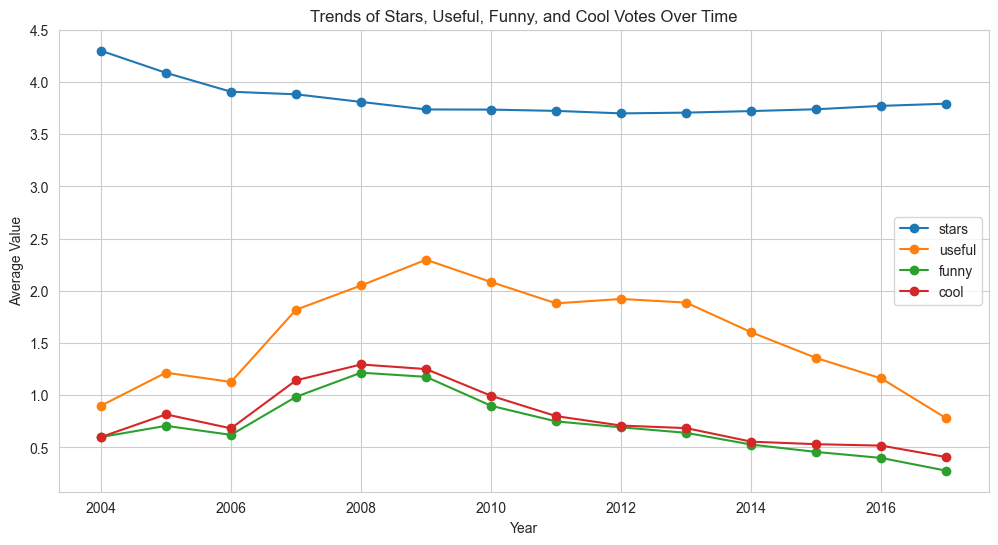

In [26]:
# Ensure the date column is in datetime format
df_yelp_review_open["date"] = pd.to_datetime(df_yelp_review_open["date"])

# Extract year from the date column
df_yelp_review_open["year"] = df_yelp_review_open["date"].dt.year

# Aggregate data by calculating the mean for each feature per year
yearly_avg = df_yelp_review_open.groupby("year")[["stars", "useful", "funny", "cool"]].mean()

# Plot all features in a single line chart
plt.figure(figsize=(12, 6))

# Iterate through each feature and plot it
for column in ["stars", "useful", "funny", "cool"]:
    plt.plot(yearly_avg.index, yearly_avg[column], marker="o", linestyle="-", label=column)

# Chart labels and formatting
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.title("Trends of Stars, Useful, Funny, and Cool Votes Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Step 9: Correlation Between Ratings and Usefulness

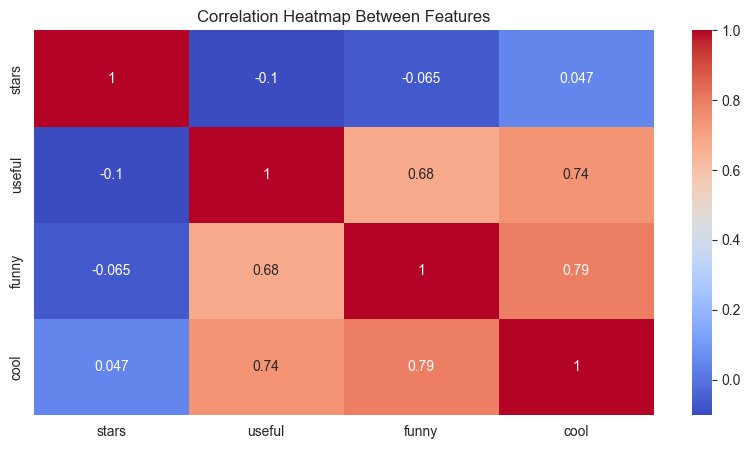

In [27]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_yelp_review_open[["stars", "useful", "funny", "cool"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap Between Features")
plt.show()

## Step 10. Word Count Analysis in Reviews

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_91026/2394096709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yelp_review_open["review_length"] = df_yelp_review_open["text"].apply(lambda x: len(str(x).split()))


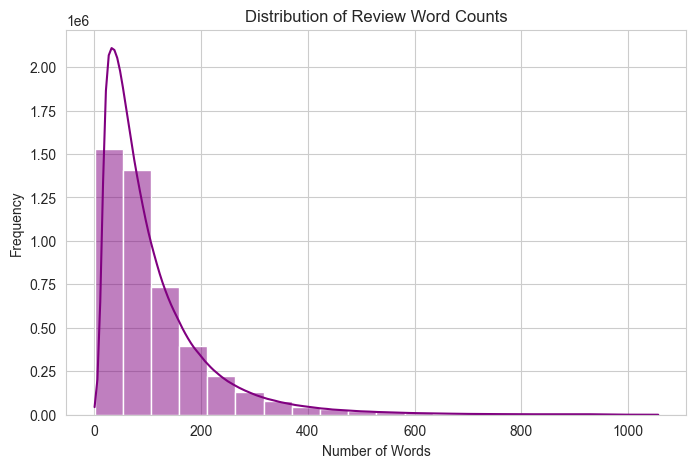

In [28]:
# Calculate word count in each review using the correct column name "text"
df_yelp_review_open["review_length"] = df_yelp_review_open["text"].apply(lambda x: len(str(x).split()))

# Plot the distribution of review lengths
plt.figure(figsize=(8, 5))
sns.histplot(df_yelp_review_open["review_length"], bins=20, kde=True, color="purple")
plt.title("Distribution of Review Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


## Step 11. Focusing on Users with Interactions at More Than 10 Businesses in *Food & Drink*

### In this analysis, we focus on users who have interacted with **more than 10 businesses in total**, specifically within the **Food & Drink** category.

### How did we filter?

### We applied a **three-step behavior-driven filter**:

### 1. **Identify users who reviewed more than 10 businesses** (across all categories):  
   #### This ensures we’re analyzing users with a history of meaningful engagement.

### 2. **Select businesses in the ‘Food & Drink’ category**:  
   #### This focuses the analysis on a relevant and high-interest domain and avoids random sampling.

### 3. **Filter for reviews** where:
   #### - The `business_id` belongs to the **Food & Drink** category  
   #### - The `user_id` belongs to users who have reviewed **more than 10 businesses**


In [34]:
# Step 1: Identify users who reviewed >10 businesses (total count, any category)
user_review_counts = df_yelp_review_open.groupby('user_id')['business_id'].count()
valid_users = user_review_counts[user_review_counts > 10].index

# Step 2: Get business_ids in the 'Food & Drink' category
food_and_drink_ids = df_yelp_business_categories[
    df_yelp_business_categories['general_category'] == 'Food & Drink'
]['business_id'].unique()

# Step 3: Filter df_yelp_review_open for:
#         - business_id in Food & Drink
#         - user_id in valid_users
df_yelp_review_open_food_drink_10 = df_yelp_review_open[
    (df_yelp_review_open['business_id'].isin(food_and_drink_ids)) &
    (df_yelp_review_open['user_id'].isin(valid_users))
].copy()

## Step 12. Yelp Review Dataset for open businesses in the Food & Drink category  (limited to 10 businesses)

### In this step of our analysis, we  review Yelp dataset for open businesses in the Food & Drink category (limited to 10 businesses). The goal is to understand the number of unique values in each column, which provides insight into the structure and variability of the dataset.


In [35]:
def perform_eda(df):
    """
    Performs Exploratory Data Analysis (EDA) on a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input dataset

    Returns:
    None
    """
    
    print("\n Unique Values Per Column:")
    print(df.nunique())

# Call the function with df_yelp_review_open
perform_eda(df_yelp_review_open_food_drink_10)


 Unique Values Per Column:
review_id        1507281
user_id            72704
business_id        50965
stars                  5
date                4417
text             1506757
useful               155
funny                130
cool                 149
year                  14
review_length        996
dtype: int64


In [37]:
# Save filtered dataset to Parquet format
df_yelp_review_open_food_drink_10.to_parquet('df_yelp_review_open_food_drink_10.parquet', index=False)
print("Filtered dataset saved as 'df_yelp_review_open_food_drink_10.parquet'")

Filtered dataset saved as 'df_yelp_review_open_food_drink_10.parquet'


## Step 13: compares two DataFrames: one original and one filtered

### This function compares two DataFrames — an original and a filtered version — and calculates the **percentage of unique values retained per column** after filtering. It's useful for understanding how much diversity remains in the filtered dataset.


In [39]:
def show_columnwise_retention(original_df, filtered_df, name="Filtered"):
    """
    Shows the percentage of unique values retained per column after filtering.
    """
    print(f"\n Column-wise Unique Value Retention in '{name}' Dataset:\n")

    original_uniques = original_df.nunique()
    filtered_uniques = filtered_df.nunique()

    retention_percentages = (filtered_uniques / original_uniques * 100).round(2)

    summary_df = pd.DataFrame({
        'Original Unique Values': original_uniques,
        'Filtered Unique Values': filtered_uniques,
        'Retention (%)': retention_percentages
    })

    return summary_df

# Usage:
show_columnwise_retention(df_yelp_review_open, df_yelp_review_open_food_drink_10, name="Food & Drink + Active Users")



 Column-wise Unique Value Retention in 'Food & Drink + Active Users' Dataset:



Original Unique Values  Filtered Unique Values  Retention (%)
review_id                     4643841                 1507281          32.46
user_id                       1256337                   72704           5.79
business_id                    146702                   50965          34.74
stars                               5                       5         100.00
date                             4530                    4417          97.51
text                          4641126                 1506757          32.47
useful                            214                     155          72.43
funny                             158                     130          82.28
cool                              175                     149          85.14
year                               14                      14         100.00
review_length                    1032                     996          96.51

# Loading Yelp Check-in Dataset

## Overview
### In this part, we are analyzing **Yelp's Check-in Dataset**, which contains timestamps of customer check-ins at various businesses. This data will help us understand customer visit patterns, seasonal trends, and business popularity.


In [112]:
df_yelp_checkin = pd.read_parquet(f"{path}/Checkin.parquet")
df_yelp_checkin.head(5)


business_id weekday   hour  checkins
0  3Mc-LxcqeguOXOVT_2ZtCg     Tue   0:00        12
1  SVFx6_epO22bZTZnKwlX7g     Wed   0:00         4
2  vW9aLivd4-IorAfStzsHww     Tue  14:00         1
3  tEzxhauTQddACyqdJ0OPEQ     Fri  19:00         1
4  CEyZU32P-vtMhgqRCaXzMA     Tue  17:00         1

## 1. Dataset Overview

### Before diving into visualizations, let’s take a quick look at the structure, size, and basic statistics of the dataset.

In [113]:
# Basic data check
df_yelp_checkin.info()
df_yelp_checkin.describe()

# Check for missing values
df_yelp_checkin.isnull().sum()

# Unique businesses
print(f"Unique businesses: {df_yelp_checkin['business_id'].nunique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911218 entries, 0 to 3911217
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   business_id  object
 1   weekday      object
 2   hour         object
 3   checkins     int64 
dtypes: int64(1), object(3)
memory usage: 119.4+ MB
Unique businesses: 146350


## 2. Heatmap of Check-ins by Weekday and Hour
### This heatmap visualizes the distribution of check-ins across different days of the week and hours of the day. It helps identify patterns in customer activity and peak traffic times for businesses.

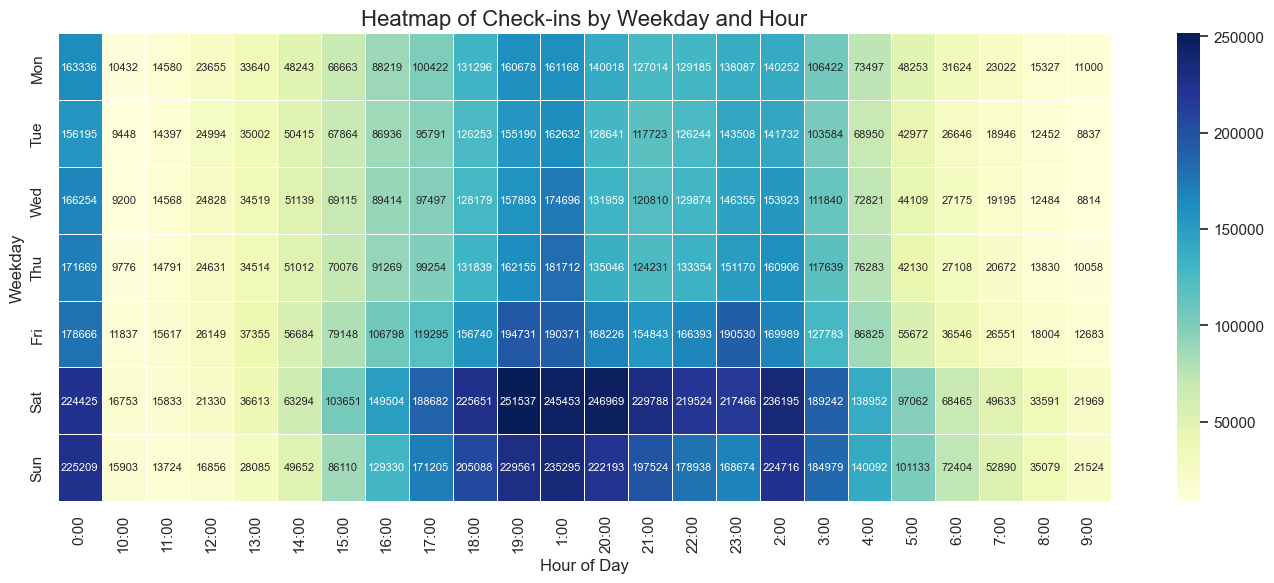

In [114]:
# Create a pivot table:
# Rows = Weekdays, Columns = Hours, Values = Sum of Check-ins
heatmap_data = df_yelp_checkin.pivot_table(
    index='weekday',
    columns='hour',
    values='checkins',
    aggfunc='sum',
    fill_value=0  # Replace NaNs with 0
)

# Reorder rows to follow natural weekday order
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data = heatmap_data.reindex(weekday_order)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_data,
    cmap='YlGnBu',         # Color palette
    annot=True,            # Show values in cells
    fmt='.0f',             # Integer formatting
    annot_kws={"size": 8}, # annotation text
    linewidths=0.5,        # Lines between cells
    linecolor='white'      # Line color
)

# Chart labels and title
plt.title('Heatmap of Check-ins by Weekday and Hour', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()


# Loading Yelp Tip Dataset

## Overview
### In this part, we are analyzing the **Yelp Tip Dataset**, which contains user-generated tips left for businesses on Yelp. Unlike reviews, tips are **short, concise comments** that provide quick insights about a business.


In [115]:
df_yelp_tip = pd.read_parquet(f"{path}/Tip.parquet")
df_yelp_tip.head(5)

text        date  likes  \
0  Great breakfast large portions and friendly wa...  2015-08-12      0   
1  Nice place. Great staff.  A fixture in the tow...  2014-06-20      0   
2                     Happy hour 5-7 Monday - Friday  2016-10-12      0   
3  Parking is a premium, keep circling, you will ...  2017-01-28      0   
4             Homemade pasta is the best in the area  2017-02-25      0   

              business_id                 user_id  
0  jH19V2I9fIslnNhDzPmdkA  ZcLKXikTHYOnYt5VYRO5sg  
1  dAa0hB2yrnHzVmsCkN4YvQ  oaYhjqBbh18ZhU0bpyzSuw  
2  dAa0hB2yrnHzVmsCkN4YvQ  ulQ8Nyj7jCUR8M83SUMoRQ  
3  ESzO3Av0b1_TzKOiqzbQYQ  ulQ8Nyj7jCUR8M83SUMoRQ  
4  k7WRPbDd7rztjHcGGkEjlw  ulQ8Nyj7jCUR8M83SUMoRQ

## 1. General Data Exploration
### Objective: Understand the structure and basic statistics of the dataset.

In [116]:
# Check dataset info
df_yelp_tip.info()

# Count unique users and businesses
unique_users = df_yelp_tip["user_id"].nunique()
unique_businesses = df_yelp_tip["business_id"].nunique()

print(f"Unique Users: {unique_users}")
print(f"Unique Businesses: {unique_businesses}")

# Replace None or NaN in 'text' with empty strings
df_yelp_tip["text"] = df_yelp_tip["text"].fillna("")

# Calculate average tip length
df_yelp_tip["tip_length"] = df_yelp_tip["text"].apply(len)
print("Average Tip Length:", df_yelp_tip["tip_length"].mean())

# Top users who left the most tips
top_users = df_yelp_tip["user_id"].value_counts().head(10)
print("\nTop 10 Users by Number of Tips:")
print(top_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098324 entries, 0 to 1098323
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   text         1098322 non-null  object
 1   date         1098324 non-null  object
 2   likes        1098324 non-null  int64 
 3   business_id  1098324 non-null  object
 4   user_id      1098324 non-null  object
dtypes: int64(1), object(4)
memory usage: 41.9+ MB
Unique Users: 271679
Unique Businesses: 112365
Average Tip Length: 63.760742731652954

Top 10 Users by Number of Tips:
user_id
mkbx55W8B8aPLgDqex7qgg    1905
6ZC-0LfOAGwaFc5XPke74w    1514
CxDOIDnH8gp9KXzpBHJYXw    1480
eZfHm0qI8A_HfvXScwIYsg    1340
O8eDScRAg6ae0l9Bc24uMA    1200
0tvCcnfJnSs55iB6mqPk3w    1192
8DGFWco9VeBAxjqsuh1aSw    1174
WJKocp9RE0KatUwh3_DkGg    1142
2EuPAGalYnP7eSxPgFCNDg    1080
5dKknvq65x-SaluuJjT0Kw     990
Name: count, dtype: int64


## 2. Distribution of Tip Length
### Objective: Understand how long Yelp tips usually are.

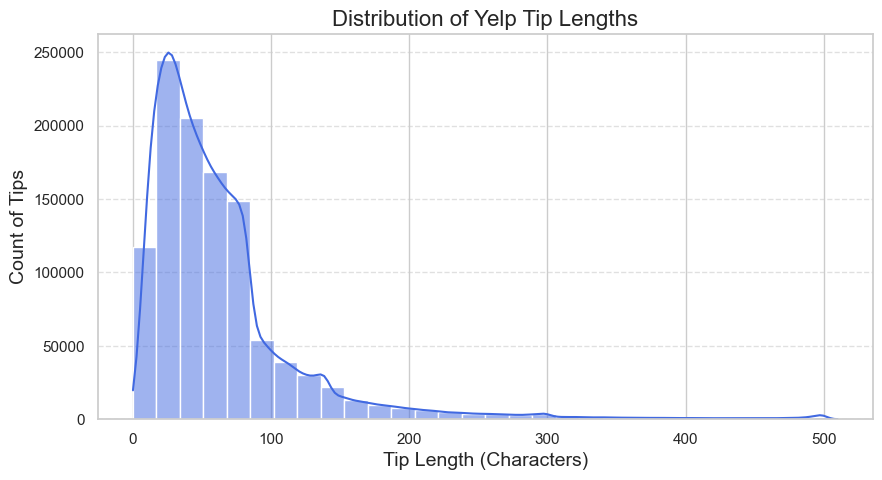

In [117]:
# Plot the distribution of tip lengths
plt.figure(figsize=(10,5))
sns.histplot(df_yelp_tip["tip_length"], bins=30, kde=True, color="royalblue")
plt.xlabel("Tip Length (Characters)", fontsize=14)
plt.ylabel("Count of Tips", fontsize=14)
plt.title("Distribution of Yelp Tip Lengths", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


## 3. Trends Over Time: Tips Per Year
### Objective: Check if tips have increased or decreased over time.

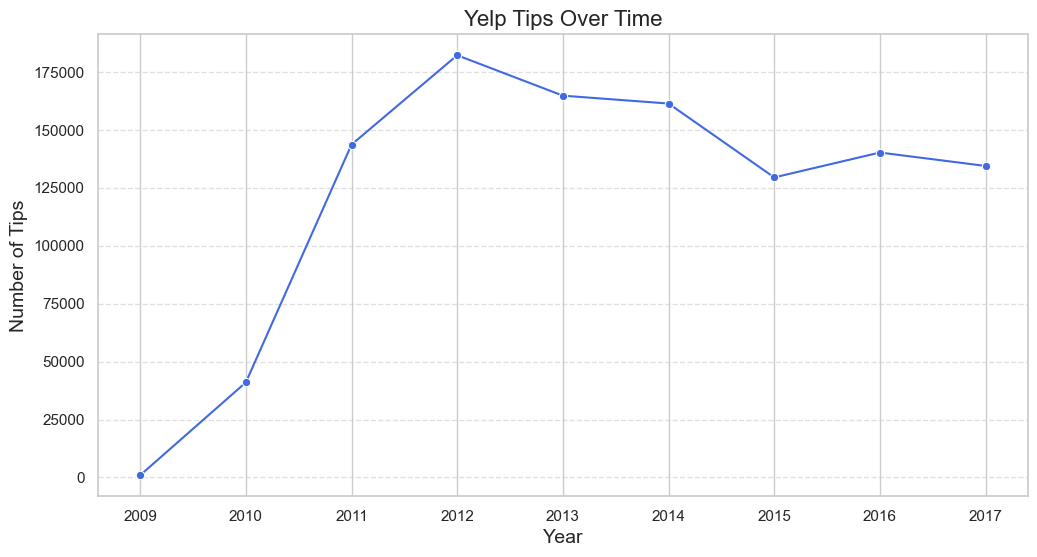

In [118]:
# Convert date column to datetime
df_yelp_tip["date"] = pd.to_datetime(df_yelp_tip["date"])

# Extract year
df_yelp_tip["year"] = df_yelp_tip["date"].dt.year

# Count tips per year
tips_per_year = df_yelp_tip["year"].value_counts().sort_index()

# Plot tips over time
plt.figure(figsize=(12,6))
sns.lineplot(x=tips_per_year.index, y=tips_per_year.values, marker="o", color="royalblue")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Tips", fontsize=14)
plt.title("Yelp Tips Over Time", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


## 4. Businesses with the Most Tips
### Objective: Identify which businesses receive the most user tips.

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_61597/653330622.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_businesses.values, y=top_businesses.index, palette="coolwarm")


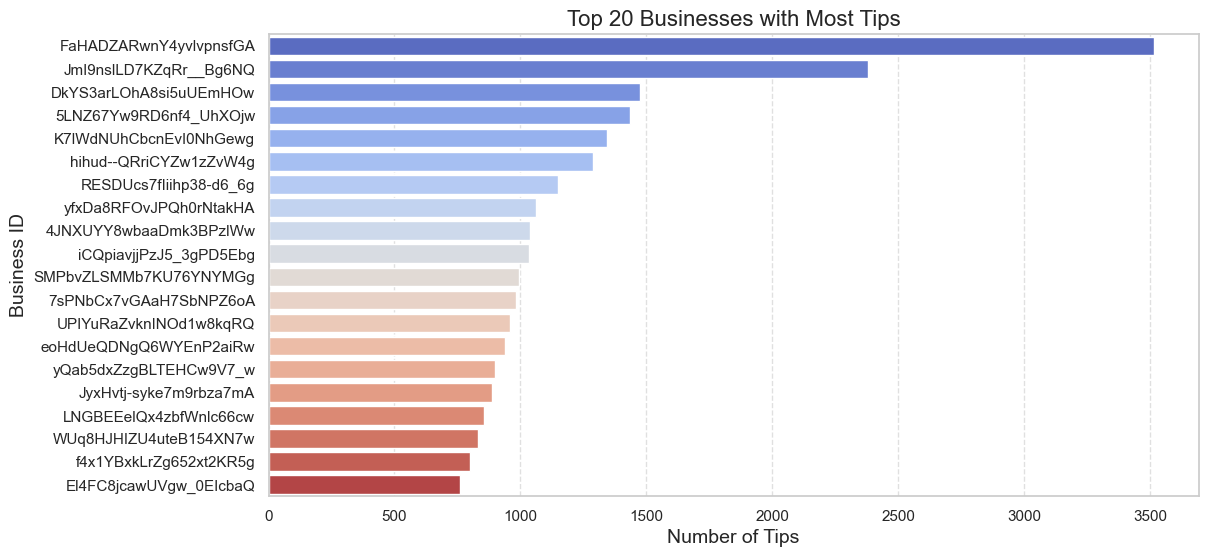

In [119]:
# Count tips per business
top_businesses = df_yelp_tip["business_id"].value_counts().head(20)

# Plot the top businesses with most tips
plt.figure(figsize=(12,6))
sns.barplot(x=top_businesses.values, y=top_businesses.index, palette="coolwarm")
plt.xlabel("Number of Tips", fontsize=14)
plt.ylabel("Business ID", fontsize=14)
plt.title("Top 20 Businesses with Most Tips", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


## 5. Distribution of Likes on Yelp Tips

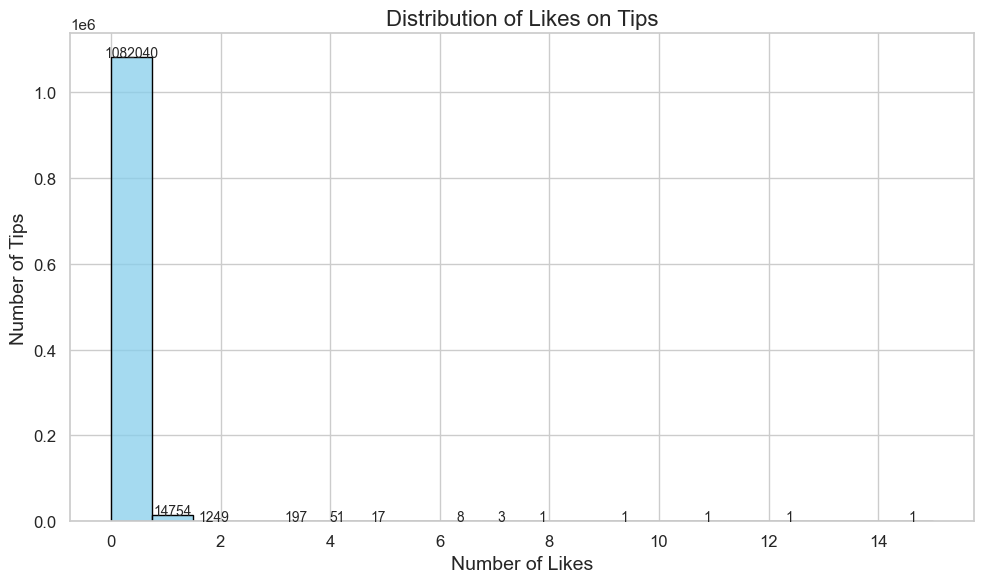

In [120]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot histogram of likes
ax = sns.histplot(df_yelp_tip["likes"], bins=20, color="skyblue", edgecolor="black")

# Title and axis labels
plt.title("Distribution of Likes on Tips", fontsize=16)
plt.xlabel("Number of Likes", fontsize=14)
plt.ylabel("Number of Tips", fontsize=14)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: Add values on top of bars (only if not too many bars)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height + 1, int(height), 
                ha="center", fontsize=10)

plt.tight_layout()
plt.show()


## 6. Top 20 Most Active Yelp Tip Users

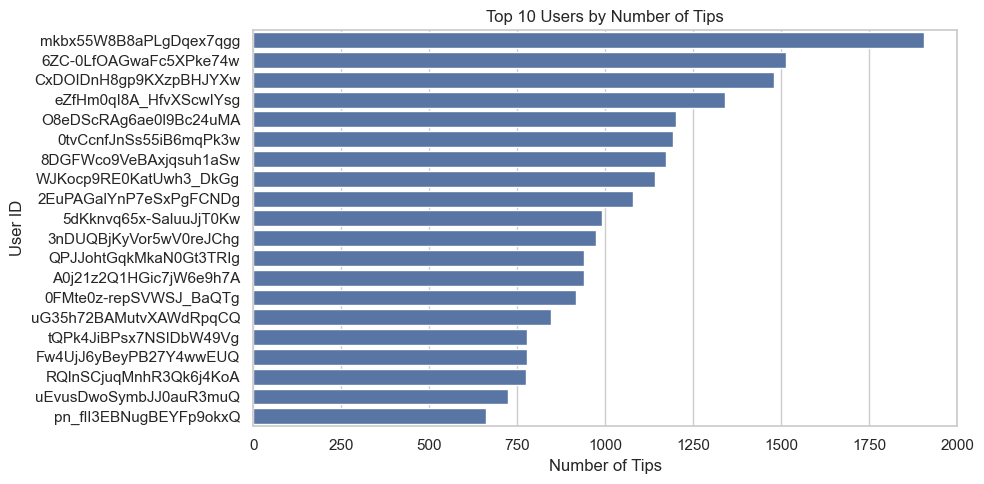

In [121]:
top_users = df_yelp_tip["user_id"].value_counts().head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_users.values, y=top_users.index)
plt.title("Top 10 Users by Number of Tips")
plt.xlabel("Number of Tips")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()


# Loading Yelp User Dataset

## Overview
### This dataset contains detailed information about Yelp users and their social engagement on the platform. Each row represents a unique user, with features capturing their activity, influence, compliments received, and more.


In [122]:
df_yelp_user = pd.read_parquet(f"{path}/User.parquet")
df_yelp_user.head(5)

user_id    name  review_count yelping_since  \
0  JJ-aSuM4pCFPdkfoZ34q0Q   Chris            10    2013-09-24   
1  uUzsFQn_6cXDh6rPNGbIFA   Tiffy             1    2017-03-02   
2  mBneaEEH5EMyxaVyqS-72A    Mark             6    2015-03-13   
3  W5mJGs-dcDWRGEhAzUYtoA  Evelyn             3    2016-09-08   
4  4E8--zUZO1Rr1IBK4_83fg    Lisa            11    2012-07-16   

                                             friends  useful  funny  cool  \
0  0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...       0      0     0   
1                                               None       0      0     0   
2                                               None       0      0     0   
3                                               None       0      0     0   
4                                               None       4      0     0   

   fans elite  ...  compliment_more  compliment_profile  compliment_cute  \
0     0  None  ...                0                   0                0   
1     0  None  ...                0                   0                0   
2     0  None  ...                0                   0                0   
3     0  None  ...                0                   0                0   
4     0  None  ...                0                   0                0   

   compliment_list  compliment_note  compliment_plain  compliment_cool  \
0                0                0                 0                0   
1                0                0                 0                0   
2                0                0                 0                0   
3                0                0                 0                0   
4                0                0                 0                0   

   compliment_funny  compliment_writer  compliment_photos  
0                 0                  0                  0  
1                 0                  0                  0  
2                 0                  0                  0  
3                 0                  0                  0  
4                 0                  1                  0  

[5 rows x 22 columns]

## 1. Data Cleaning & Feature Engineering

In [123]:
# Convert 'yelping_since' to datetime
df_yelp_user['yelping_since'] = pd.to_datetime(df_yelp_user['yelping_since'])

# Fill missing or 'None' values in friends
df_yelp_user['friends'] = df_yelp_user['friends'].fillna('').replace('None', '')

# Count number of friends
df_yelp_user['friend_count'] = df_yelp_user['friends'].apply(lambda x: len(x.split(',')) if x else 0)

# Calculate account age
current_year = pd.Timestamp.now().year
df_yelp_user['account_age'] = current_year - df_yelp_user['yelping_since'].dt.year

# Total compliments received
compliment_cols = [col for col in df_yelp_user.columns if 'compliment_' in col]
df_yelp_user['total_compliments'] = df_yelp_user[compliment_cols].sum(axis=1)

# Fill 'elite' and calculate years as elite
df_yelp_user['elite'] = df_yelp_user['elite'].fillna('').replace('None', '')
df_yelp_user['elite_years'] = df_yelp_user['elite'].apply(lambda x: len(x.split(',')) if x else 0)


## 2. Total Compliments by Type

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_61597/2940454067.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_compliments.values, y=total_compliments.index, palette='magma')


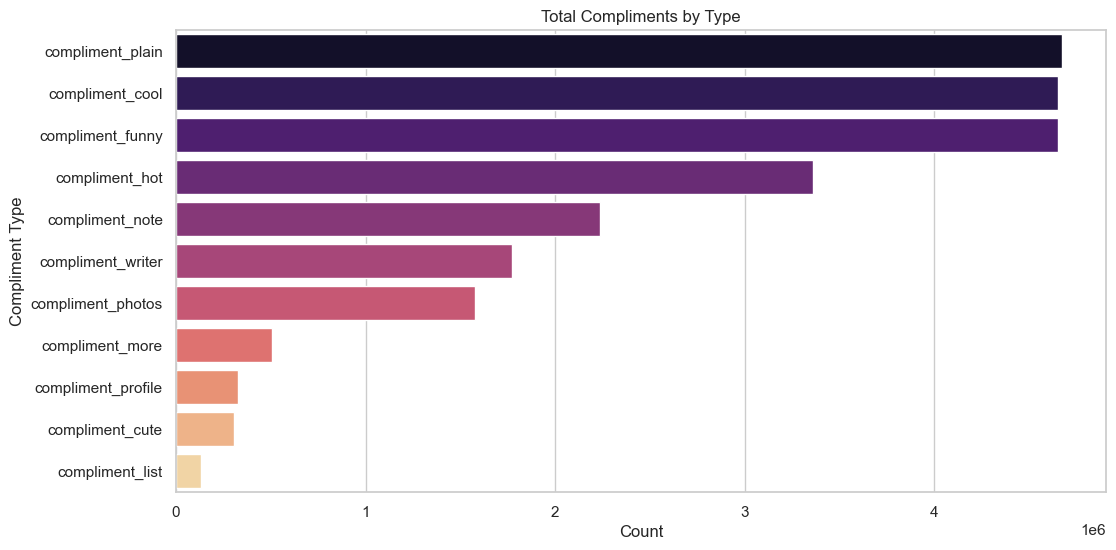

In [124]:
# Total compliments per type
total_compliments = df_yelp_user[compliment_cols].sum().sort_values(ascending=False)

sns.barplot(x=total_compliments.values, y=total_compliments.index, palette='magma')
plt.title('Total Compliments by Type')
plt.xlabel('Count')
plt.ylabel('Compliment Type')
plt.show()


## 3. Correlation Heatmap of Key User Features

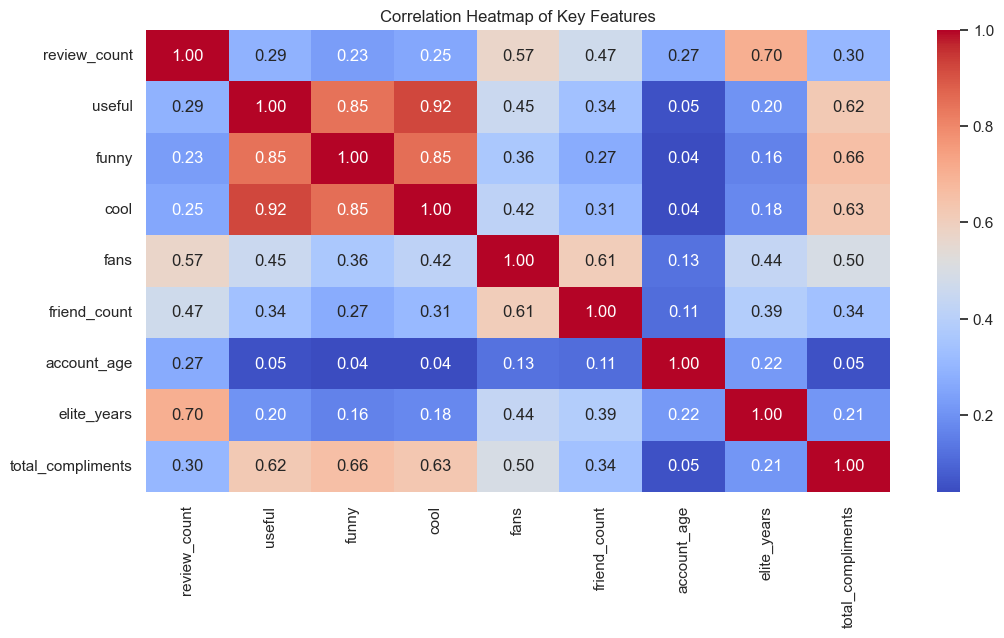

In [125]:
numeric_cols = ['review_count', 'useful', 'funny', 'cool', 'fans', 
                'friend_count', 'account_age', 'elite_years', 'total_compliments']

sns.heatmap(df_yelp_user[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Key Features')
plt.show()


## 4. Yelp User Sign-Ups Over Time

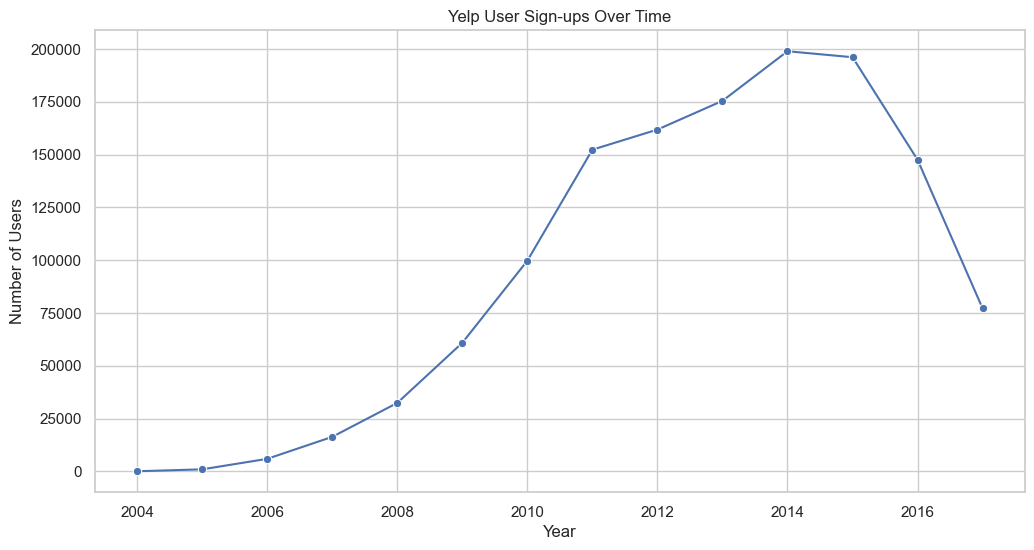

In [126]:
# Join year
df_yelp_user['join_year'] = df_yelp_user['yelping_since'].dt.year
user_growth = df_yelp_user['join_year'].value_counts().sort_index()

sns.lineplot(x=user_growth.index, y=user_growth.values, marker='o')
plt.title('Yelp User Sign-ups Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Users')
plt.show()


## 5. Extracting and Visualizing Gender from User Names

### We’ll use the gender-guesser library to infer gender based on the first name in the name column.


In [127]:
# Initialize the detector
d = gender.Detector()

# Example: df_yelp_user is your DataFrame, and 'name' column exists
# Apply gender detection on first name
df_yelp_user['gender'] = df_yelp_user['name'].apply(
    lambda x: d.get_gender(x.split()[0]) if pd.notnull(x) else 'unknown'
)

# Clean up labels (combine similar or ambiguous ones)
gender_map = {
    'male': 'male',
    'mostly_male': 'male',
    'female': 'female',
    'mostly_female': 'female',
    'andy': 'unknown',  # androgynous
    'unknown': 'unknown'
}

df_yelp_user['gender'] = df_yelp_user['gender'].map(gender_map)

## 6. Gender Distribution Plot

/var/folders/y_/y0hkq8td15q6ncrtyfqdnbtw0000gn/T/ipykernel_61597/329946262.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


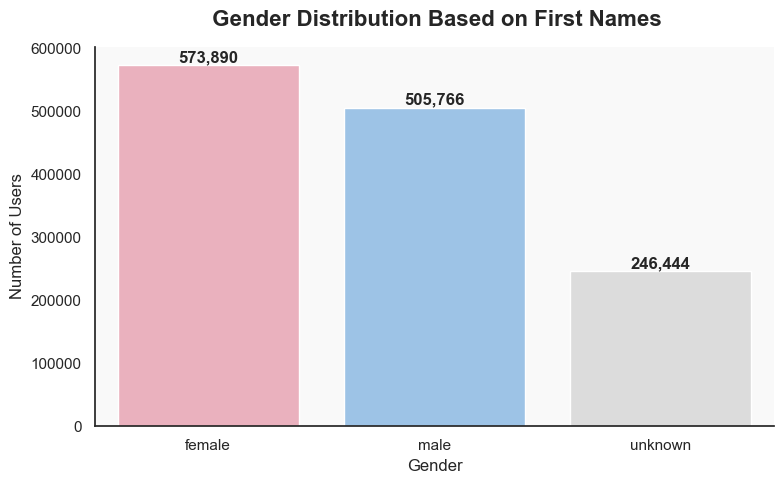

In [128]:
# Count genders
gender_counts = df_yelp_user['gender'].value_counts().reindex(['female', 'male', 'unknown'])

# Set style
sns.set(style="white", rc={"axes.facecolor": "#f9f9f9"})

# Custom pastel palette
colors = ['#f4a7b9', '#91c4f2', '#dcdcdc']

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    palette=colors,
    ax=ax
)

# Add value labels on bars
for bar in bars.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 10,
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Final touches
ax.set_title(" Gender Distribution Based on First Names", fontsize=16, weight='bold', pad=15)
ax.set_xlabel("Gender", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()